In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import netCDF4
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
sys.path.append('/Users/gbromley/code/python_utilities/')
from python_data_functions import extract_months

In [2]:
data_dir = '/Volumes/ATLAS/reanalysis/'
nc_temp_file = 'NA_2m_temp_1900-2010.nc'
nc_dewp_file = 'NA_dwpt_2m_1900-2010.nc'
months = pd.date_range('1900-01-01','2010-12-01',freq='MS')

In [3]:
#load nc file
nc_temp = xr.open_dataset(data_dir+nc_temp_file)
temp = nc_temp['t2m']

nc_dewp = xr.open_dataset(data_dir+nc_dewp_file)
dewp = nc_dewp['d2m']

In [17]:
t_season='MJJ'
t_months=[4,5,6]
start_year = '1970-01-01'
end_year = '2010-12-01'
ext_e = -90
ext_w = -120
ext_n = 55
ext_s = 30


In [16]:
def is_season(month):
    return (month >= 5) & (month <= 7)


def rel_hum(tk, tdk):
    tc = tk-273.15
    tdc = tdk-273.15
    e = 0.611*np.exp((17.27*tdc/(237.3+tdc)))
    es = 0.611*np.exp((17.27*tc/(237.3+tc)))
    #et = 0.611*np.exp((17.27*tdc/(237.3+tdc))
    return(100.0*(e/es))


In [7]:
test = map(rel_hum,temp.values, dewp.values)

relh = list(test)

In [8]:
temp.time

<xarray.DataArray 'time' (time: 1332)>
array(['1900-01-01T00:00:00.000000000', '1900-02-01T00:00:00.000000000',
       '1900-03-01T00:00:00.000000000', ...,
       '2010-10-01T00:00:00.000000000', '2010-11-01T00:00:00.000000000',
       '2010-12-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 1900-03-01 ...
Attributes:
    long_name: time

In [9]:
dr_relh = xr.DataArray(relh, coords=[temp.time,temp.latitude,temp.longitude],dims=['time','latitude','longitude'], name='relh')


In [10]:
dr_relh

<xarray.DataArray 'relh' (time: 1332, latitude: 81, longitude: 141)>
array([[[ 71.77864482,  71.69108235,  71.64284436, ...,  72.55471217,
          72.57473177,  72.60373104],
        [ 70.13532396,  69.90659493,  69.70184083, ...,  72.29859807,
          72.49615823,  72.7013042 ],
        [ 69.8416128 ,  69.58985152,  69.36470013, ...,  72.03487631,
          72.42553621,  72.80816928],
        ..., 
        [ 73.88602938,  73.71617431,  73.6120251 , ...,  73.95816903,
          74.66063049,  75.35709737],
        [ 73.25540559,  73.21258163,  73.15313617, ...,  75.04550028,
          75.77917854,  76.51909597],
        [ 72.72005873,  72.82596754,  72.78572777, ...,  76.15670118,
          76.91685078,  77.68949149]],

       [[ 73.17739154,  73.11941947,  72.9591402 , ...,  74.11824445,
          73.98870152,  73.85969023],
        [ 71.8687572 ,  71.75347434,  71.62114014, ...,  74.51699791,
          74.48327987,  74.43185159],
        [ 71.64459045,  71.51171043,  71.3953496 , 

In [11]:
dr_relh.dims

('time', 'latitude', 'longitude')

In [ ]:

dr_relh[0,0,0]

In [ ]:
test_4

In [18]:
relh_1950=dr_relh.sel(time=slice(start_year,end_year))
#season_1950 = temp_1950.sel(time=temp_1950['time.month']==t_months)
season_1950 = relh_1950.sel(time=is_season(relh_1950['time.month']))
jja_1950 = season_1950.groupby('time.year').mean(dim='time')

clim_30= dr_relh.sel(time=slice('1981-01-01','2010-12-01'))
clim_months_30 = clim_30.sel(time=is_season(clim_30['time.month']))
jja_30 = clim_months_30.mean(dim='time')

In [ ]:
jja_30

In [13]:
spatial_trend = dr_relh.isel(time=1).copy(deep=True)
#pvalues= temp.isel(time=1).copy(deep=True)

In [19]:
for i in np.arange(0,len(dr_relh['latitude'])):
    for j in np.arange(0,len(dr_relh['longitude'])):
        series = jja_1950[:,i,j]
        anom = series-jja_30[i,j]
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0,len(anom)),anom)
        spatial_trend[i,j]=slope*10
        #pvalues[i,j]=p_value
        #print(i)


In [ ]:
#spatial_trend.to_dataset().to_netcdf(data_dir+'spatial_trends_temp_'+t_season+'_'+start_year+'mtwb'+'.nc')

/Users/gbromley/anaconda/lib/python3.5/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


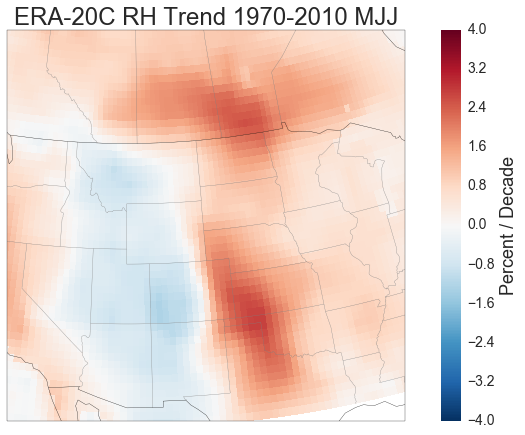

In [22]:
fig, ax = plt.subplots();
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-111.0,central_latitude=46.0,false_easting=0.0, false_northing=0.0, standard_parallels=(40.0, 50.0), globe=None))
ax.set_global()
test = spatial_trend.plot.pcolormesh(axes = ax, transform=ccrs.PlateCarree(),vmin=-4, vmax=4, cmap='RdBu_r')
#ax = plt.axes(projection=ccrs.LambertConformal())

ax.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
plt.title('ERA-20C RH Trend 1970-2010 '+t_season,fontsize=24)
test.colorbar.set_label('Percent / Decade',fontsize=18)
test.colorbar.ax.tick_params(labelsize=14)
fig.set_size_inches(13,7)
fig.set_dpi=1200.0
plt.savefig('ERA-20C_relh_'+t_season+'_1970.png',bbox_inches='tight')
plt.show()

In [ ]:
anom_series = jja_1950-jja_30.sel(season=t_season)
extent = anom_series.sel(latitude=np.arange(ext_s,ext_n,step=.5))
extent = extent.sel(longitude=np.arange(ext_w+360,ext_e+360,step=.5))
extent_series = extent.mean(dim=['latitude','longitude'])
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0,len(extent_series)),extent_series.values)
line = slope*np.arange(0,len(extent_series.values))+intercept



fig, ax = plt.subplots();
plt.scatter(extent_series['year'],extent_series.values, c=extent_series.values,vmin=-3,vmax=2,cmap='RdBu_r',s=30);
#trend = ax.plot(anom['time'],line)
base = np.zeros(len(extent_series.values))
ax.plot(extent_series['year'],base,c='grey')
ax.set_title('North America 2m Temperature Anomaly '+t_season+' 1970-2010')
ax.set_xlabel('Year')
ax.set_ylabel('Temp Anomaly [C]')
trend = ax.plot(extent_series['year'],line)
#fig.savefig('2m_temp_anom_'+t_season+'_na_sp_1970.png')

